In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import multiprocessing
import multiprocessing as mp
from time import time
from multiprocessing import Queue
print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  12


In [2]:
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.kernels import QuantumKernel
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=128)

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#EE9A4D","#FFFFFF","#4863A0"])

from time import time
from circuit_generate import generate_circuit_paper, generate_circuit_2local, generate_circuit_2local_swap

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("whitegrid")

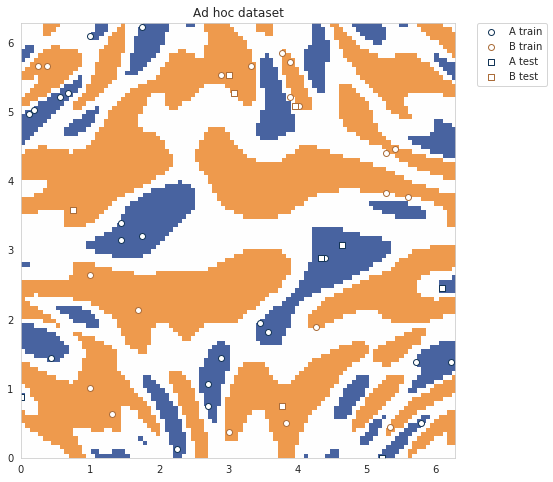

In [4]:
from qiskit_machine_learning.datasets import ad_hoc_data
train_x, train_y, test_x, test_y, total = (ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, include_sample_total=True, one_hot=False))

plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(total).T,
    interpolation="nearest",
    origin="lower",
    cmap=CMAP,
    extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", facecolors="w", edgecolors="#123456", label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", facecolors="w", edgecolors="#AA6C39", label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", facecolors="w", edgecolors="#123456", label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", facecolors="w", edgecolors="#AA6C39", label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset")
plt.grid(False)
plt.show()

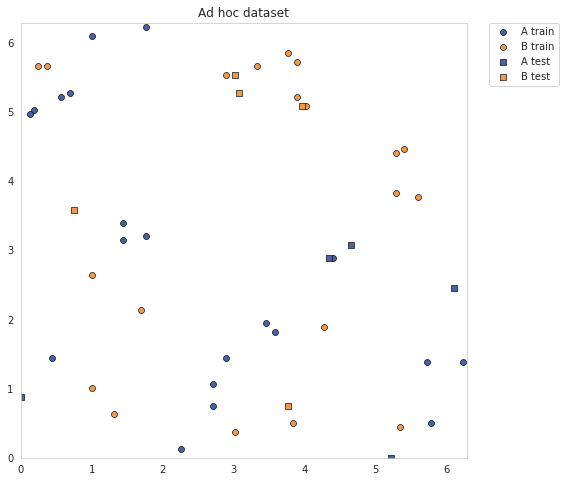

In [5]:
plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset")
plt.grid(False)
plt.show()

In [6]:
MODE = "2local" # paper、2local、2local_swap
QUBIT = 2
FEATURE = 2

BIT = 5 if MODE == "paper" else 6
GENE = 20
POPULATION = multiprocessing.cpu_count() # 12

POOLSIZE = 4
OFFSPRINGSIZE = POPULATION - POOLSIZE
PROB = 12
MUTATION_PROB = PROB/GENE

GENERATION = 200
EARLYSTOP = 20

In [7]:
def cost_func(acc, r, h, cnot, swap=0):
    
    if acc == 0.0: acc = 0.01

    gate_cost = r + 2*h + 5*cnot+11*swap
    fit = gate_cost + 40 / acc**2 - 40
    return round(fit,1)

def cost_gate(r,h,cnot,swap=0): return r+2*h+5*cnot+11*swap

In [8]:
def task(i, pop, q, mode):
    if mode == "paper": qc_i, r_i, h_i, cnot_i = generate_circuit_paper(pop[i], QUBIT, FEATURE)
    elif mode == "2local": qc_i, r_i, h_i, cnot_i = generate_circuit_2local(pop[i], QUBIT, FEATURE)
    elif mode == "2local_swap": qc_i, r_i, h_i, cnot_i, swap_i = generate_circuit_2local_swap(pop[i], QUBIT, FEATURE)
    kernel = QuantumKernel(feature_map=qc_i, quantum_instance=quantum_instance,)
    model = SVC(kernel=kernel.evaluate)
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
#     print("Score : {:3f}, r_i : {:3d}, h_i : {:3d}, cnot_i : {:3d}".format(score, r_i, h_i, cnot_i))
    if mode == "paper": q.put([score, r_i, h_i, cnot_i])
    elif mode == "2local": q.put([score, r_i, h_i, cnot_i])
    elif mode == "2local_swap": q.put([score, r_i, h_i, cnot_i, swap_i])


Generation: 1 , Cost: 202.88 , Time: 21.84 s
Accuracy: [0.5, 0.6, 0.3, 0.5, 0.9, 0.8, 0.6, 0.6, 0.7, 0.5, 0.4, 0.4]
Fitness: [145.0, 97.1, 424.4, 145.0, 24.4, 50.5, 103.1, 91.1, 64.6, 151.0, 229.0, 238.0]

Generation: 2 , Cost: 60.92 , Time: 44.97 s
Accuracy: [0.8, 0.8, 0.7, 0.6, 0.7, 0.5, 0.7, 0.6, 0.6, 0.7, 0.7, 0.5]
Fitness: [37.5, 50.5, 64.6, 91.1, 65.6, 144.0, 75.6, 99.1, 87.1, 64.6, 56.6, 135.0]

Generation: 3 , Cost: 47.52 , Time: 68.28 s
Accuracy: [0.8, 0.8, 0.7, 0.8, 0.4, 0.7, 0.5, 0.6, 0.7, 0.4, 0.6, 0.5]
Fitness: [37.5, 50.5, 56.6, 45.5, 231.0, 59.6, 132.0, 95.1, 66.6, 235.0, 88.1, 145.0]

Generation: 4 , Cost: 51.62 , Time: 91.11 s
Accuracy: [0.9, 0.8, 0.8, 0.6, 0.7, 0.6, 0.4, 0.5, 0.9, 0.6, 0.6, 0.7]
Fitness: [24.4, 45.5, 50.5, 86.1, 63.6, 93.1, 234.0, 143.0, 31.4, 89.1, 95.1, 58.6]

Generation: 5 , Cost: 40.38 , Time: 113.59 s
Accuracy: [0.9, 1.0, 0.7, 0.8, 0.7, 0.4, 0.7, 0.7, 0.9, 0.7, 0.5, 0.8]
Fitness: [24.4, 22.0, 64.6, 50.5, 59.6, 228.0, 67.6, 58.6, 30.4, 64.6, 141.


Generation: 42 , Cost: 17.62 , Time: 939.27 s
Accuracy: [1.0, 1.0, 1.0, 0.8, 0.8, 0.7, 0.3, 0.5, 0.7, 0.6, 0.6, 0.2]
Fitness: [11.0, 12.0, 17.0, 30.5, 40.5, 57.6, 414.4, 137.0, 53.6, 94.1, 88.1, 970.0]

Generation: 43 , Cost: 14.35 , Time: 960.4 s
Accuracy: [1.0, 0.9, 1.0, 1.0, 0.6, 0.7, 0.7, 0.4, 0.6, 0.5, 0.6, 0.3]
Fitness: [11.0, 21.4, 17.0, 8.0, 88.1, 54.6, 56.6, 227.0, 89.1, 134.0, 82.1, 419.4]

Generation: 44 , Cost: 12.0 , Time: 981.27 s
Accuracy: [1.0, 1.0, 1.0, 1.0, 0.5, 0.7, 0.4, 0.5, 0.8, 0.7, 0.7, 0.6]
Fitness: [8.0, 11.0, 17.0, 12.0, 137.0, 57.6, 223.0, 132.0, 34.5, 57.6, 58.6, 86.1]

Generation: 45 , Cost: 16.7 , Time: 1002.78 s
Accuracy: [0.9, 1.0, 1.0, 0.9, 0.6, 0.6, 0.8, 0.7, 0.7, 0.4, 0.5, 0.5]
Fitness: [17.4, 11.0, 12.0, 26.4, 94.1, 89.1, 43.5, 52.6, 56.6, 226.0, 136.0, 138.0]

Generation: 46 , Cost: 24.75 , Time: 1024.48 s
Accuracy: [1.0, 0.9, 0.7, 1.0, 0.7, 0.7, 0.7, 0.6, 0.4, 0.5, 0.5, 0.4]
Fitness: [11.0, 21.4, 49.6, 17.0, 56.6, 59.6, 63.6, 88.1, 223.0, 134.0, 1

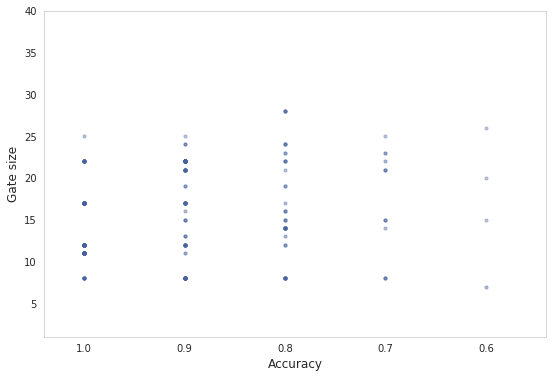

In [9]:
pop, COST, obj_GATE, obj_ACC= [], [], [], []
early_stop, threshold= 0, 100

sns.set_style("whitegrid")
plt.figure(figsize=(9,6))
plt.xlim(1.04,0.54)
plt.ylim(1,GENE*2)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Gate size", fontsize=12)
plt.grid(False)

for i in range(POPULATION):
    genes = np.random.randint(2, size=(GENE,BIT))
    pop.append(genes)
    
start_time = time()
for g in range(GENERATION):

    inputs = range(POPULATION)
    process_list= []

    q_list = [Queue() for i in range(len(inputs))]
    RESULt = []

    for i in inputs:
        process_list.append(mp.Process(target = task, args = (i, pop,  q_list[i], MODE)))
        process_list[-1].start()

    for i in inputs:
        process_list[i].join()

    for q in q_list:
        RESULt.append(q.get())
    
    end_time = time()

    FITNESS, SCORE, QC_R, QC_H, QC_CNOT, QC_SWAP, plt_acc, plt_gate = [], [], [], [], [], [], [], []
    cost_pool ,obj_gate, obj_acc = 0, 0, 0

    for i in range(POPULATION):
        SCORE.append(round(RESULt[i][0],2))
        QC_R.append(RESULt[i][1])
        QC_H.append(RESULt[i][2])
        QC_CNOT.append(RESULt[i][3])
        if MODE == "2local_swap": QC_SWAP.append(RESULt[i][4])
        
    for i in range(POPULATION):
        if MODE == "2local_swap": fit = cost_func(SCORE[i], QC_R[i], QC_H[i], QC_CNOT[i], QC_SWAP[i])
        else: fit = cost_func(SCORE[i], QC_R[i], QC_H[i], QC_CNOT[i])
        FITNESS.append(fit)
    
    for i in range(POOLSIZE):
        cost_p = FITNESS[i]
        if MODE == "2local_swap": obj_g = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i], QC_SWAP[i])
        else: obj_g = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i])
        obj_a = SCORE[i]
        
        plt_gate.append(obj_g)
        plt_acc.append(obj_a)
        cost_pool += cost_p
        obj_gate += obj_g
        obj_acc += obj_a
     
    if cost_pool/POOLSIZE < threshold:
        threshold = cost_pool/POOLSIZE
        early_stop = 0    
    early_stop += 1
    
    COST.append(cost_pool/POOLSIZE)
    obj_GATE.append(obj_gate/POOLSIZE)
    obj_ACC.append(obj_acc/POOLSIZE)
    plt.scatter(plt_acc, plt_gate, s=10, c="#4863A0", alpha=(g+GENERATION/2)/(1.5*GENERATION))
    
    print("\nGeneration:", g+1,", Cost:", round(COST[g],2) ,", Time:", round(end_time-start_time,2),"s")
    print("Accuracy:", SCORE)
    print("Fitness:", FITNESS)

    if g == GENERATION: break
    if early_stop == EARLYSTOP: break

    parents = []

    for i in range(POOLSIZE):
        FitnessIndex = np.where(FITNESS == min(FITNESS))
        parents.append(pop[FitnessIndex[0][0]])
        del FITNESS[FitnessIndex[0][0]]
        del pop[FitnessIndex[0][0]]

    for i in range(OFFSPRINGSIZE):
        ll,rr = np.random.randint(POOLSIZE), np.random.randint(POOLSIZE) 
        parent_left, parent_right = parents[ll], parents[rr]
        cross_point = np.random.randint(GENE-1) 
        offspring = np.concatenate((parent_left[:cross_point],parent_right[cross_point:]), axis=0)

        for ii in range(PROB):
            mutation_index = np.random.randint(GENE) 
            mutation_bit = np.random.randint(BIT) 
            offspring[mutation_index][mutation_bit] = (offspring[mutation_index][mutation_bit]+1)%2

        parents.append(offspring)       
    pop = parents    
plt.show()

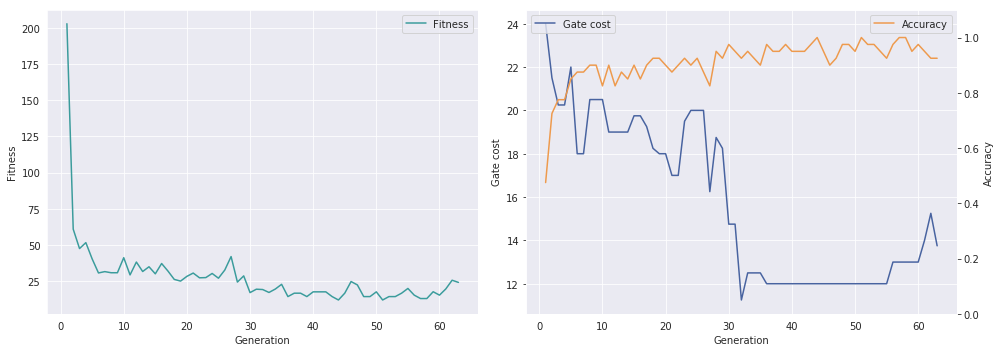

In [10]:
sns.set_style("darkgrid")
obj_x, obj_y1, obj_y2 = np.arange(len(obj_ACC)), np.array(obj_GATE), np.array(obj_ACC)
cost_x, cost_y = np.arange(len(obj_GATE)), np.array(COST)

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax1=axes[1]
ax1.set_xlabel('Generation')
ax1.set_ylabel('Gate cost')
ax1.plot(obj_x+1, obj_y1, label="Gate cost", color="#4863A0")
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 
ax2.set_ylabel('Accuracy')
ax2.plot(obj_x+1, obj_y2, label="Accuracy", color="#EE9A4D")
ax2.grid(False)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1.1)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax3=axes[0]
ax3.set_xlabel('Generation')
ax3.set_ylabel('Fitness')
ax3.plot(cost_x+1, cost_y, label="Fitness", color="#3B9C9C")
ax3.tick_params(axis='y')
ax3.legend(loc = "uppper right")

fig.tight_layout() 
plt.show()

R gate: 7 
H gate: 2 
CNOT gate: 0


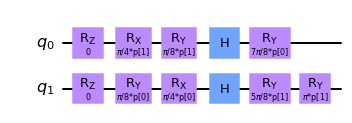

In [11]:
DISPLAY = 1
if MODE == "paper":
    qc_display, r_display, h_display, cnot_display = generate_circuit_paper(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display)
if MODE == "2local":
    qc_display, r_display, h_display, cnot_display = generate_circuit_2local(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display)
if MODE == "2local_swap":
    qc_display, r_display, h_display, cnot_display, swap_display = generate_circuit_2local_swap(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display,"\nSWAP gate:",swap_display)    
qc_display.draw(output="mpl")

In [12]:
ga_kernel = QuantumKernel(feature_map=qc_display, quantum_instance=quantum_instance,)
model_ga = SVC(kernel=ga_kernel.evaluate)
qsvm = model_ga.fit(train_x, train_y)
q_score = model_ga.score(test_x, test_y)

print(f'Test kernel acc: {q_score}')

Test kernel acc: 1.0


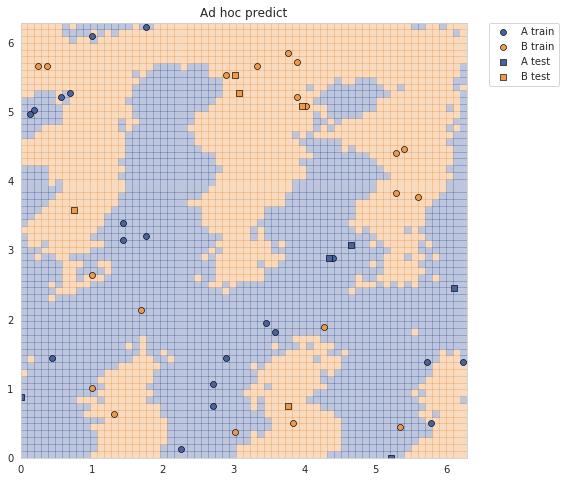

QSVM test score: 1.0
Cost time: 1415.250131 s


In [13]:
GRID = np.pi/32 # pi/32:1600s

sns.set_style("whitegrid")
def make_big_meshgrid(x, y, h=GRID): 
    xx, yy = np.meshgrid(np.arange(0, 2*np.pi+GRID, h), np.arange(0, 2*np.pi+GRID, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = train_x[:, 0], train_x[:, 1]
bbxx, bbyy = make_big_meshgrid(X0, X1)
bbmeshgrid_features = np.column_stack((bbxx.ravel(), bbyy.ravel()))

meshgrid_time1 = time()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.36)

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc predict")
plt.grid(False)
plt.show()

print(f'QSVM test score: {q_score}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))

In [14]:
from qiskit.circuit.library import ZZFeatureMap
zz_feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
zz_kernel = QuantumKernel(feature_map=zz_feature_map, quantum_instance=quantum_instance,)
model_zz = SVC(kernel=zz_kernel.evaluate)
qsvm_zz = model_zz.fit(train_x, train_y)
q_score_zz = model_zz.score(test_x, test_y)

print(f'Test kernel acc: {q_score_zz}')

Test kernel acc: 1.0


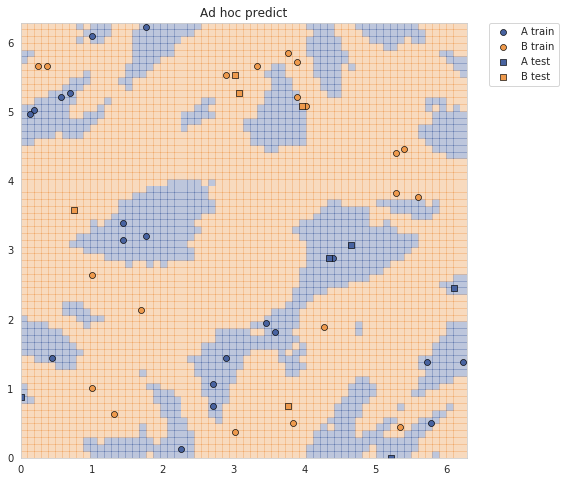

ZZFeatureMap test score: 1.0
Cost time: 1304.747604 s


In [15]:
meshgrid_time1 = time()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])
meshgrid_colors = qsvm_zz.predict(bbmeshgrid_features)

plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.36)

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc predict")
plt.grid(False)
plt.show()

print(f'ZZFeatureMap test score: {q_score_zz}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))